In [1]:
import pandas as pd
import numpy as np
import os
import re
import string
import pickle
from datetime import datetime, date, time
from dateutil.parser import parse

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
import scipy

from matplotlib.colors import ListedColormap
from matplotlib.path import Path
from folium.plugins import MarkerCluster

from pandas.plotting import scatter_matrix
from scipy import stats
from scipy import sparse

from itertools import chain
from itertools import combinations

from collections import Counter

from sklearn.cluster import SpectralClustering
import networkx as nx


In [3]:
import folium
import descartes

# Loading Data

In [176]:
df_m = pd.read_csv('tmdb_5000_movies.csv')
df_c = pd.read_csv('tmdb_5000_credits.csv')


## merge two dataset together to make sure that they have same index

In [178]:
df_all = pd.merge(df_c,df_m,how = 'inner',on = 'title')
df_all.drop(columns='movie_id',inplace = True)
df_all['new_id'] = range(len(df_all))
df_all.set_index(['new_id'],inplace = True)

### Jobs in movie industry

In [184]:
#convert dict to DataFrame
df_crew = pd.DataFrame(df_all['crew'])
df_crew['crew'] = df_crew['crew'].apply(lambda x:pd.DataFrame(eval(x)))

In [185]:
#extract all the jobs from each movie
flag = 0
def find_job(x):
    df_t = x
    try:
        temp_l = list(df_t['job'].unique())
        return temp_l
    except:
        return []
    
df_crew['jobs'] = df_crew['crew'].apply(lambda x:find_job(x))

In [32]:
#generate a job list that contain all the categories
jobs = list(chain.from_iterable(df_crew['jobs'].tolist()))
df_jobs = pd.DataFrame.from_dict(Counter(jobs), orient='index')
df_jobs.sort_values(by = 0,ascending= False, inplace = True)
df_jobs.reset_index(inplace = True)

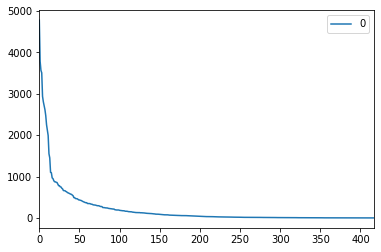

In [33]:
df_jobs.plot()

It can be seen that the jobs distribution is a long tail distribution, there are a lot of missing values for the crews' records

#### similarity based on crew

In [34]:
df_jobs.head(20)

,index,0
0,Director,4779
1,Producer,3786
2,Editor,3568
3,Director of Photography,3508
4,Screenplay,2940
5,Original Music Composer,2808
6,Production Design,2715
7,Casting,2617
8,Costume Design,2474
9,Executive Producer,2252


In [36]:
# we only use the top 10 high frequently appeared jobs for further analysis
top_job = list(df_jobs.head(10)['index'].values)

In [187]:
#give a new number for selected jobs and than extract them and encode them
def find_crew(job,x):
    df_t = x
    try:
        return list(df_t[df_t['job'] == job]['name'].values)
    except:
        return []

def encoding(dic,vec,x):
    vec_in = vec.copy()
    for i in x:
        vec_in[dic.get(i)] = 1
    return vec_in

In [188]:
for i in top_job:
    df_crew[i] = df_crew['crew'].apply(lambda x:find_crew(i,x))

In [41]:
df_crew['movie'] = df_all['original_title']
df_dir = df_crew.explode('Director')
df_pro = df_crew.explode('Producer')

In [42]:
#selected the movie under top director and producer
df_p= pd.DataFrame(df_pro.groupby('Producer').size()).sort_values(by=[0],ascending=False)
df_d= pd.DataFrame(df_dir.groupby('Director').size()).sort_values(by=[0],ascending=False)
top_producer = df_p.head(10).index.to_list()
top_director = df_d.head(10).index.to_list()


In [43]:
#movies that belong to top 10 director
df_d_d= df_dir[(df_dir['Director'].isin(top_director))]
df_d_d['Director'] = df_d_d['Director'].apply(lambda x:[x])
df_d_d = df_d_d.reset_index()

D:\anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### top director

In [44]:
df_d_d = df_d_d.drop_duplicates(subset = ['movie'])
df_d_d = df_d_d.reset_index()

In [45]:
#build vectors for each job for futher using to compute the similarity for movies based on co-crews
for i in top_job:
    locals()[i+'_list'] = list(set(list(chain.from_iterable(df_d_d[i].tolist()))))
    locals()[i+'_dict'] = pd.DataFrame(locals()[i+'_list']).to_dict()[0]
    locals()[i+'_dict'] = dict(zip(locals()[i+'_dict'].values(), locals()[i+'_dict'].keys()))
    vector = np.zeros(len(list(chain.from_iterable(df_d_d[i].tolist()))))
    dic = locals()[i+'_dict'].copy()
    df_d_d[i+'_vec'] = df_d_d[i].apply(lambda x:encoding(dic,vector,x))

In [47]:
#build the adjancy metrix for top 10 directors' movies
adj_d = np.zeros([len(df_d_d.index),len(df_d_d.index)])
#['Producer_vec', 'Editor_vec', 'Director of Photography_vec','Screenplay_vec', 'Original Music Composer_vec','Production Design_vec', 'Casting_vec', 'Costume Design_vec','Executive Producer_vec']

for n in df_d_d.columns[17:34]:
    print(n)
    temp_adj =  np.zeros([len(df_d_d.index),len(df_d_d.index)])
    for i in df_d_d.index:
        for j in df_d_d.index[i+1:]:
            dis = 0
            dif = df_d_d[n][i]-df_d_d[n][j]
            if (df_d_d[n][j].sum() == 0) and (df_d_d[n][j].sum() == 0):
                dis  = 0
            else:
                dis = 1 - np.square(dif).sum()/np.count_nonzero(df_d_d[n][i]+df_d_d[n][j])
            temp_adj[i,j] = dis
            temp_adj[j,i] = dis
    locals()[n.replace(' ','_')[:-4]+'_adj'] = temp_adj
    adj_d = adj_d + temp_adj

Editor_vec
Director of Photography_vec
Screenplay_vec
Original Music Composer_vec
Production Design_vec
Casting_vec
Costume Design_vec
Executive Producer_vec


In [48]:
top_dir_dic = pd.DataFrame(top_director).to_dict()[0]
top_dir_dic = dict(zip(top_dir_dic.values(), top_dir_dic.keys()))

In [190]:
#labels_d is the true label
labels_d = df_d_d['Director'].apply(lambda x:top_dir_dic.get(x[0])) 
#labels_d2 is the label predicted by Spectral Clustering
sc = SpectralClustering(10,affinity='precomputed', n_init=100,n_neighbors= 10)
labels_d2 = sc.fit(adj_d).labels_

D:\anaconda3\envs\ada\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


## Graph of movies based on crewsget

In [211]:
from sklearn.metrics import f1_score

df_pre_d = df_d_d[['Director']]
df_pre_d['truth'] = list(labels_d)
df_pre_d['predicted'] = list(labels_d2)
# f1_score(list(labels_d),list(labels_d2),average='micro')

D:\anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [212]:
df_pre_d = pd.DataFrame(df_pre_d.groupby('truth')['predicted'].value_counts()).unstack()['predicted']


In [214]:
df_pre_d[df_pre_d.fillna(0)

predicted,0,1,2,3,4,5,6,7,8,9
truth,,,,,,,,,,
0,0.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,19.0,2.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0
4,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0
5,12.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0
7,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0


In [50]:
G_mc_d = nx.from_numpy_matrix(adj)
G_mc_c_d = max(nx.connected_component_subgraphs(G_mc_d), key=len)

In [51]:
print('The number of nodes of the giant components is {}'.format(G_mc_c_d.number_of_nodes()))

The number of nodes of the giant components is 173


In [52]:
eig_val_1_d = nx.linalg.normalized_laplacian_spectrum(G_mc_d)
# eig_val_1 = nx.laplacian_spectrum(G1)

The number of eigenvalues equal to 0 is 10.
The number of connected components is 10.


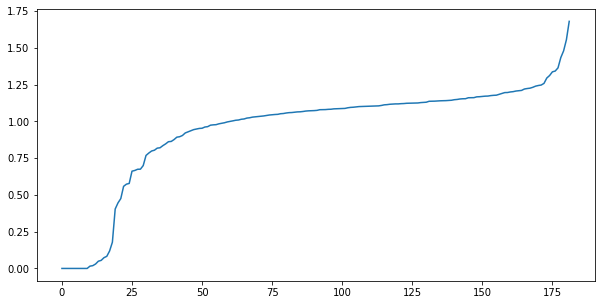

In [53]:
plt.figure(figsize=(10, 5))
plt.plot(eig_val_1_d, '-');
print('The number of eigenvalues equal to 0 is {}.'.format(Counter(eig_val_1_d < 1e-10)[1]))
print('The number of connected components is {}.'.format(nx.number_connected_components(G_mc_d)))

The multiplicity of the eigenvalue $\lambda_1$ equals the number of connected components of the graph.

D:\anaconda3\envs\ada\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


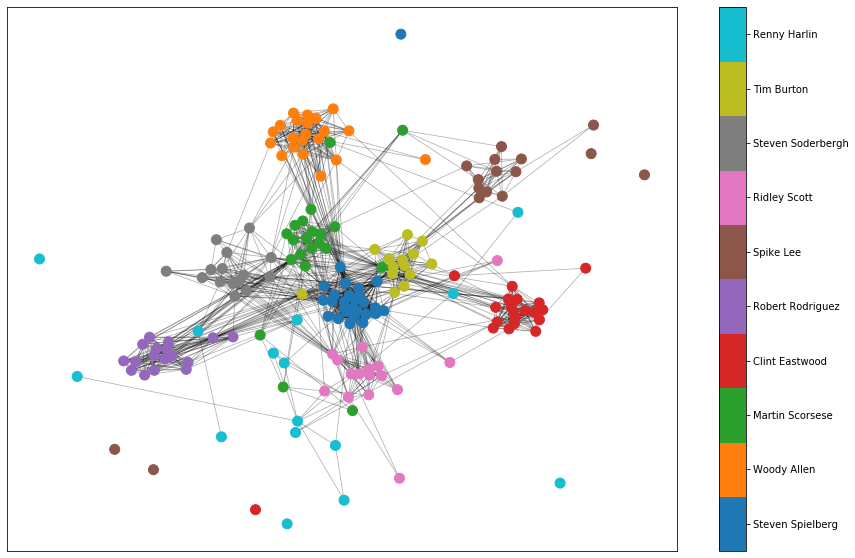

In [126]:
coords_G_mc_d = nx.spring_layout(G_mc_d, k=0.3)
fig=plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(G_mc_d, coords_G_mc_d, node_size=100, node_color=labels_d, cmap='tab10',vmin=0, vmax=10)
nx.draw_networkx_edges(G_mc_d, coords_G_mc_d, alpha=0.3, width=0.8)
cbar = plt.colorbar(im, ticks=np.array(range(10))+0.5)
cbar.set_ticklabels(list(top_director))  


the majority movies made by same directors are grouped together

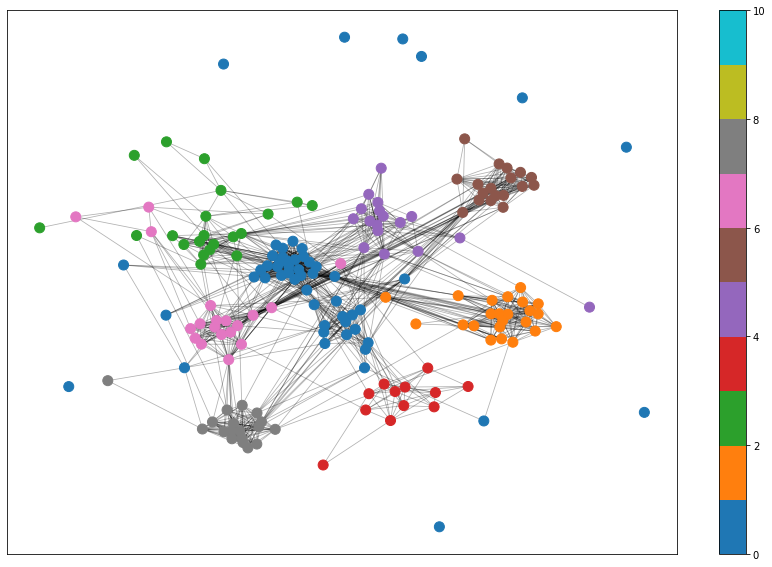

In [55]:
fig=plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(G_mc_d, coords_G_mc_d, node_size=100, node_color=labels_d2, cmap='tab10',vmin=0, vmax=10)
nx.draw_networkx_edges(G_mc_d, coords_G_mc_d, alpha=0.3, width=0.8)
plt.colorbar(im)

using predicted labels for the movies we can see that the predict results are pretty well

In [56]:
def merge_crews(x):
    df_t = x
    list_t = []
#     list_t.append(df_t[3][0])
    for i in df_t[top_job].values:
        list_t=list_t+i
    return list_t

In [57]:
df_d_d['all_crew'] = df_d_d.apply(lambda x:merge_crews(x),axis=1)

In [60]:
list_crew_d = list(Counter(list(chain.from_iterable(df_d_d['all_crew'].values.tolist()))))
crew_dict_d = pd.DataFrame(list_crew_d).to_dict()[0]
crew_dict_d = dict(zip(crew_dict_d.values(), crew_dict_d.keys()))

In [61]:
def build_net(x,lists):
    l = len(lists)
    row = np.repeat(x,len(x))
    col = np.tile(x,len(x))
    data = np.ones(len(col))
    net = sparse.csr_matrix((data,(row,col)),shape=(l,l))
    return net

In [62]:
dict_job_number = pd.DataFrame(top_job).to_dict()[0]
dict_job_number= dict(zip(dict_job_number.values(), dict_job_number.keys()))

In [63]:
df_crews_list_d = pd.DataFrame(crew_dict_d.values(),index=crew_dict_d.keys(),columns=['id'])


In [64]:
list_cs_d = []
for i in df_crews_list_d.index:
    job_t = 'D'
    if i in top_director:
        job_t = 'Director' 
    elif i in top_producer:
        job_t = 'Producer'
    else:
        for n in top_job[2:]:
            if i in locals()[n+'_list']:
                job_t = n
                break
    if job_t == 'D':
        for m in top_job[:2]:
            if i in locals()[m+'_list']:
                job_t = m
    list_cs_d.append(job_t)

In [65]:
df_crews_list_d['job'] = list_cs_d
dict_crew_job_d = df_crews_list_d.drop(columns = ['id']).to_dict()['job']

In [66]:
labels_c_job = []
for i in list_crew_d:
    ecoding = dict_crew_job_d.get(i)
    ecoding = dict_job_number.get(ecoding)
    labels_c_job.append(ecoding)

In [67]:
def find_id(ids,x):
    list_id = []
    for i in x:
        if i in ids:
            list_id.append(ids.get(i))
    return list_id

In [68]:
#generate the adjancy matrix for co-appearance of crews that in top director selected movie
df_d_d['crew_ids'] = df_d_d['all_crew'].apply(lambda x:find_id(crew_dict_d,x))
df_d_d['crew_net'] = df_d_d['crew_ids'].apply(lambda x:build_net(x,list_crew_d))
adj_crew_d = df_d_d['crew_net'].values.sum().todense()

#### graph_crews

In [69]:
G_crew_d = nx.from_numpy_matrix(adj_crew_d)
G_crew_c_d = max(nx.connected_component_subgraphs(G_crew_d), key=len)


In [70]:
print('The number of nodes of the giant components is {}'.format(G_crew_c_d.number_of_nodes()))

The number of nodes of the giant components is 921


In [71]:
eig_val_crew_d = nx.linalg.normalized_laplacian_spectrum(G_crew_d)
# eig_val_1 = nx.laplacian_spectrum(G1)

The number of eigenvalues equal to 0 is 1.
The number of connected components is 1.


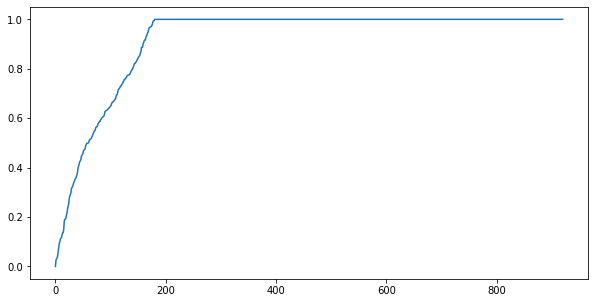

In [72]:
plt.figure(figsize=(10, 5))
plt.plot(eig_val_crew_d, '-');
print('The number of eigenvalues equal to 0 is {}.'.format(Counter(eig_val_crew_d < 1e-10)[1]))
print('The number of connected components is {}.'.format(nx.number_connected_components(G_crew_d)))

The multiplicity of the eigenvalue $\lambda_1$ equals the number of connected components of the graph.

In [73]:
coords_G_crew_d = nx.spring_layout(G_crew_d, k=0.05)

D:\anaconda3\envs\ada\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


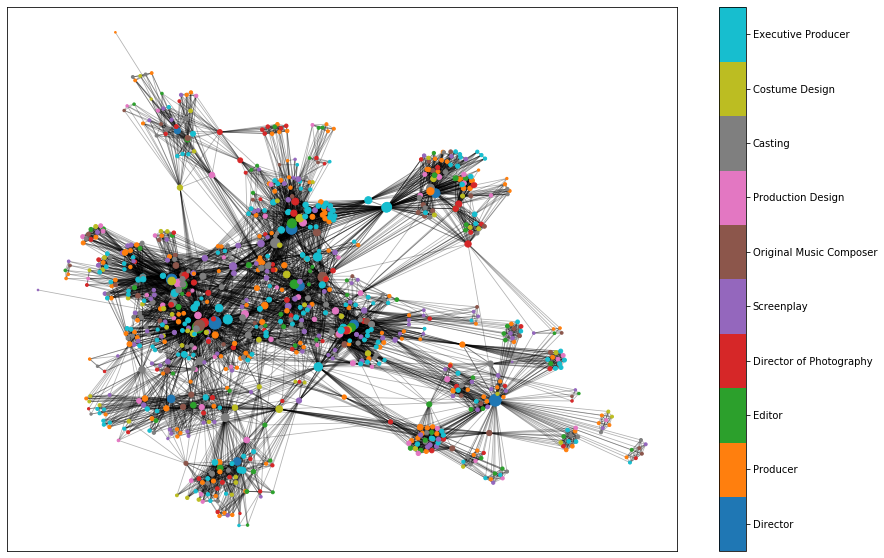

In [215]:
# coords_G_crew = nx.spring_layout(G_crew, k=0.3)
fig=plt.subplots(figsize=(15, 10))
im=nx.draw_networkx_nodes(G_crew_d, coords_G_crew_d,node_size=np.array(list(nx.degree_centrality(G_crew_d).values()))*800,node_color=labels_c_job, cmap='tab10',vmin=0,vmax =10)
nx.draw_networkx_edges(G_crew_d, coords_G_crew_d, alpha=0.3, width=0.8,weight = True)
# ax.set_title('Gaussian noise with horizontal colorbar')

cbar = plt.colorbar(im, ticks=np.array(range(10))+0.5)
cbar.set_ticklabels(list(dict_job_number.keys()))  


In the crews' network that built for top directors, most of the crews group around the director who they often work with,and Directors have larger degree_centrality that others 

In [75]:
df_crews_list_d['degree_centrality'] = list(nx.degree_centrality(G_crew_d).values())
# df_crews_list['degree_centrality'] = list(nx.degree_centrality(G_crew).values())

In [77]:
df_crews_list_d.groupby('job')['degree_centrality'].mean()

job
Casting                    0.024765
Costume Design             0.021989
Director                   0.115326
Director of Photography    0.021310
Editor                     0.023707
Executive Producer         0.023853
Original Music Composer    0.025128
Producer                   0.018556
Production Design          0.023931
Screenplay                 0.017643
Name: degree_centrality, dtype: float64

### Top producer

In [78]:
df_p_p= df_pro[(df_pro['Producer'].isin(top_producer))]
df_p_p['Producer'] = df_p_p['Producer'].apply(lambda x:[x])

D:\anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [79]:
df_p_p = df_p_p.drop_duplicates(subset = ['movie'])
df_p_p = df_p_p.reset_index()

In [80]:
for i in top_job[0:]:
    locals()[i+'_list'] = list(set(list(chain.from_iterable(df_p_p[i].tolist()))))
    locals()[i+'_dict'] = pd.DataFrame(locals()[i+'_list']).to_dict()[0]
    locals()[i+'_dict'] = dict(zip(locals()[i+'_dict'].values(), locals()[i+'_dict'].keys()))
    vector = np.zeros(len(list(chain.from_iterable(df_p_p[i].tolist()))))
    dic = locals()[i+'_dict'].copy()
    df_p_p[i+'_vec'] = df_p_p[i].apply(lambda x:encoding(dic,vector,x))

In [81]:
adj_p= np.zeros([len(df_p_p.index),len(df_p_p.index)])

for n in df_p_p.columns[16:34]:
    print(n)
    temp_adj =  np.zeros([len(df_p_p.index),len(df_p_p.index)])
    for i in df_p_p.index:
        for j in df_p_p.index[i+1:]:
            dis = 0
            dif = df_p_p[n][i]-df_p_p[n][j]
            if (df_p_p[n][j].sum() == 0) and (df_p_p[n][j].sum() == 0):
                dis  = 0
            else:
                dis = 1 - np.square(dif).sum()/np.count_nonzero(df_p_p[n][i]+df_p_p[n][j])
            temp_adj[i,j] = dis
            temp_adj[j,i] = dis
    locals()[n.replace(' ','_')[:-4]+'_adj'] = temp_adj
    adj_p = adj_p + temp_adj

Editor_vec
Director of Photography_vec
Screenplay_vec
Original Music Composer_vec
Production Design_vec
Casting_vec
Costume Design_vec
Executive Producer_vec


In [82]:
top_pro_dic = pd.DataFrame(top_producer).to_dict()[0]
top_pro_dic = dict(zip(top_pro_dic.values(), top_pro_dic.keys()))


In [216]:
#labels_p are truth
labels_p = df_p_p['Producer'].apply(lambda x:top_pro_dic.get(x[0])) 
# labels_p2 are predicted labels
sc = SpectralClustering(affinity='precomputed', n_init=100,n_neighbors= 10)
labels_p2 = sc.fit(adj_p).labels_

D:\anaconda3\envs\ada\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


## Graph of movies based on crewsget

In [217]:
G_mc_p = nx.from_numpy_matrix(adj_p)
G_mc_c_p = max(nx.connected_component_subgraphs(G_mc_p), key=len)

In [218]:
print('The number of nodes of the giant components is {}'.format(G_mc_p.number_of_nodes()))

The number of nodes of the giant components is 320


In [219]:
eig_val_p = nx.linalg.normalized_laplacian_spectrum(G_mc_p)
# eig_val_1 = nx.laplacian_spectrum(G1)

The number of eigenvalues equal to 0 is 6.
The number of connected components is 6.


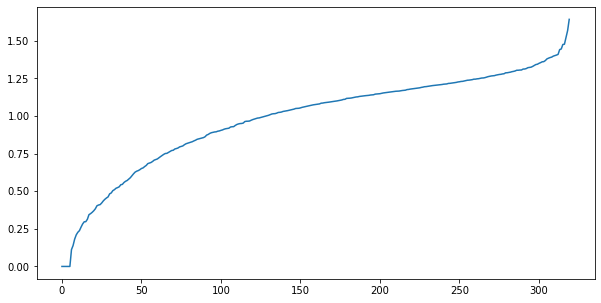

In [220]:
plt.figure(figsize=(10, 5))
plt.plot(eig_val_p, '-');
print('The number of eigenvalues equal to 0 is {}.'.format(Counter(eig_val_p < 1e-10)[1]))
print('The number of connected components is {}.'.format(nx.number_connected_components(G_mc_p)))

The multiplicity of the eigenvalue $\lambda_1$ equals the number of connected components of the graph.

D:\anaconda3\envs\ada\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


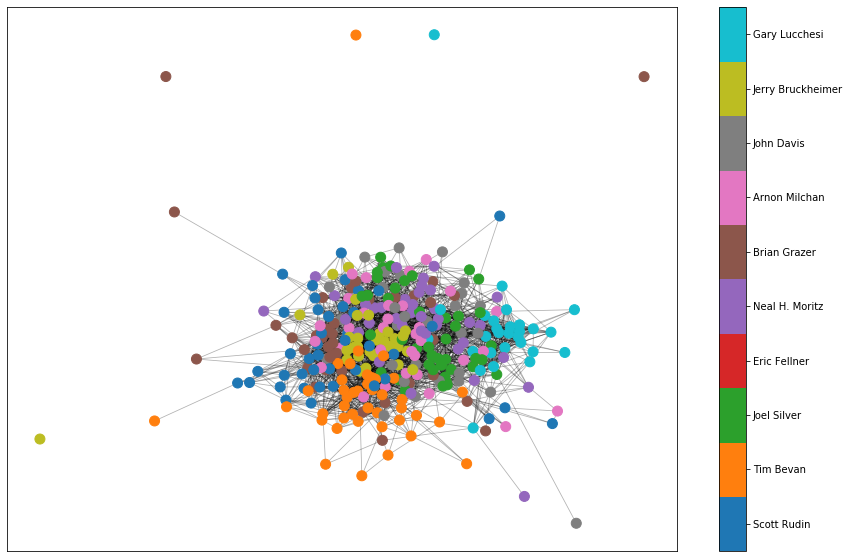

In [221]:
coords_G_mc_p = nx.spring_layout(G_mc_p, k=0.15)
fig=plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(G_mc_p, coords_G_mc_p, node_size=100, node_color=labels_p, cmap='tab10',vmin=0, vmax=10)
nx.draw_networkx_edges(G_mc_p, coords_G_mc_p, alpha=0.3, width=0.8)
cbar = plt.colorbar(im, ticks=np.array(range(10))+0.5)
cbar.set_ticklabels(list(top_producer))  

in the graph drawn among movies selected by producers, there is no obvious grouping of nodes, but they are mixed and distributed in the space with other nodes of the same class.

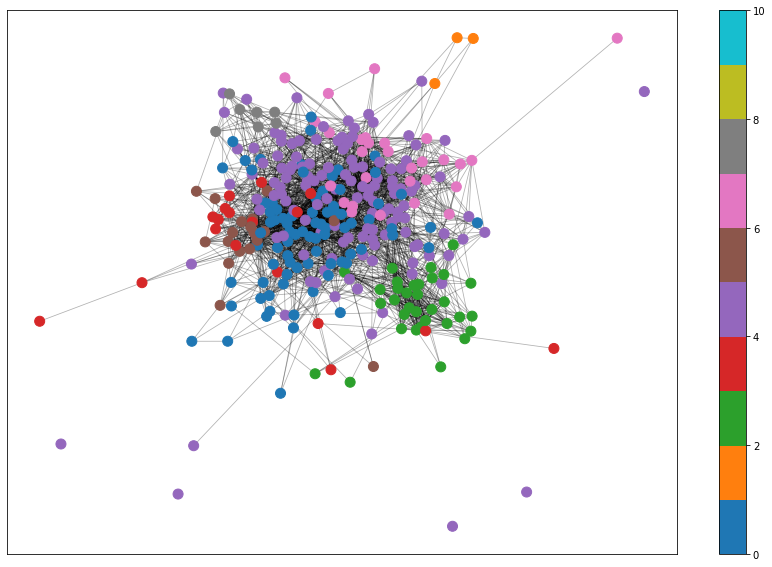

In [129]:
fig=plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(G_mc_p, coords_G_mc_p, node_size=100, node_color=labels_p2, cmap='tab10',vmin=0, vmax=10)
nx.draw_networkx_edges(G_mc_p, coords_G_mc_p, alpha=0.3, width=0.8)
plt.colorbar(im)

even the spectral clustering result is not so good, this might indicate that the producer don't hargly work with same group people

In [90]:
def merge_crews_p(x):
    df_t = x
    list_t = []
    list_t.append(df_t[3][0])
    for i in df_t[df_p_p.columns[4:13]].values:
        list_t=list_t+i
    return list_t

In [91]:
df_p_p['all_crew'] = df_p_p.apply(lambda x:merge_crews_p(x),axis=1)

In [92]:
df_p_p['all_crew']

0      [Gore Verbinski, Jerry Bruckheimer, Stephen E....
1      [Gore Verbinski, Jerry Bruckheimer, Stephen E....
2      [Gore Verbinski, Jerry Bruckheimer, Craig Wood...
3      [Rob Marshall, Jerry Bruckheimer, David Brenne...
4      [Ridley Scott, Brian Grazer, Pietro Scalia, Jo...
                             ...                        
315    [Noah Baumbach, Scott Rudin, Jennifer Lame, Sa...
316    [Max Joseph, Tim Bevan, Terel Gibson, Meaghan ...
317    [Fenton Bailey, Brian Grazer, Jeremy Simmons, ...
318                   [Barry W. Blaustein, Brian Grazer]
319    [Stephen Frears, Tim Bevan, Mick Audsley, Oliv...
Name: all_crew, Length: 320, dtype: object

In [93]:
list_crew_p = list(Counter(list(chain.from_iterable(df_p_p['all_crew'].values.tolist()))))
crew_dict_p = pd.DataFrame(list_crew_p).to_dict()[0]
crew_dict_p = dict(zip(crew_dict_p.values(), crew_dict_p.keys()))

In [94]:
def build_net(x,lists):
    l = len(lists)
    row = np.repeat(x,len(x))
    col = np.tile(x,len(x))
    data = np.ones(len(col))
    net = sparse.csr_matrix((data,(row,col)),shape=(l,l))
    return net

In [95]:
dict_job_number = pd.DataFrame(top_job).to_dict()[0]
dict_job_number= dict(zip(dict_job_number.values(), dict_job_number.keys()))

In [96]:
df_crews_list_p = pd.DataFrame(crew_dict_p.values(),index=crew_dict_p.keys(),columns=['id'])


In [97]:
list_cs_p = []
for i in df_crews_list_p.index:
    job_t = 'D'
    if i in top_director:
        job_t = 'Director' 
    elif i in top_producer:
        job_t = 'Producer'
    else:
        for n in top_job[2:]:
            if i in locals()[n+'_list']:
                job_t = n
                break
    if job_t == 'D':
        for m in top_job[:2]:
            if i in locals()[m+'_list']:
                job_t = m
    list_cs_p.append(job_t)

In [98]:
top_producer[0]

'Scott Rudin'

In [99]:
df_crews_list_p['job'] = list_cs_p
dict_crew_job_p = df_crews_list_p.drop(columns = ['id']).to_dict()['job']

In [100]:
labels_c_job_p = []
for i in list_crew_p:
    ecoding = dict_crew_job_p.get(i)
    ecoding = dict_job_number.get(ecoding)
    labels_c_job_p.append(ecoding)

In [222]:
#build the adjancy matrix for co-appearance of crews that in top director selected movie
df_p_p['crew_ids'] = df_p_p['all_crew'].apply(lambda x:find_id(crew_dict_p,x))
df_p_p['crew_net'] = df_p_p['crew_ids'].apply(lambda x:build_net(x,list_crew_p))
adj_crew_p = df_p_p['crew_net'].values.sum().todense()

#### graph_crews

In [104]:
G_crew_p = nx.from_numpy_matrix(adj_crew_p)
G_crew_c_p = max(nx.connected_component_subgraphs(G_crew_p), key=len)

In [105]:
print('The number of nodes of the giant components is {}'.format(G_crew_c_p.number_of_nodes()))

The number of nodes of the giant components is 1919


In [106]:
eig_val_crew_p = nx.linalg.normalized_laplacian_spectrum(G_crew_p)
# eig_val_1 = nx.laplacian_spectrum(G1)

The number of eigenvalues equal to 0 is 1.
The number of connected components is 1.


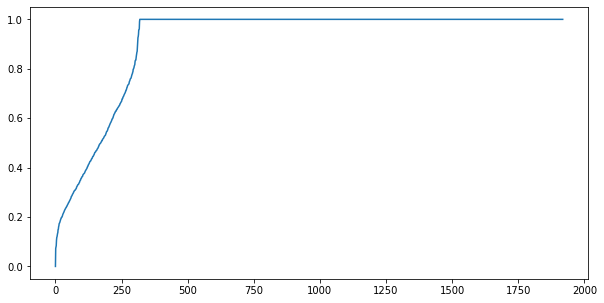

In [107]:
plt.figure(figsize=(10, 5))
plt.plot(eig_val_crew_p, '-');
print('The number of eigenvalues equal to 0 is {}.'.format(Counter(eig_val_crew_p < 1e-10)[1]))
print('The number of connected components is {}.'.format(nx.number_connected_components(G_crew_c_p)))

The multiplicity of the eigenvalue $\lambda_1$ equals the number of connected components of the graph.

In [108]:
coords_G_crew_p = nx.spring_layout(G_crew_p, k=0.1,weight = 'weight')

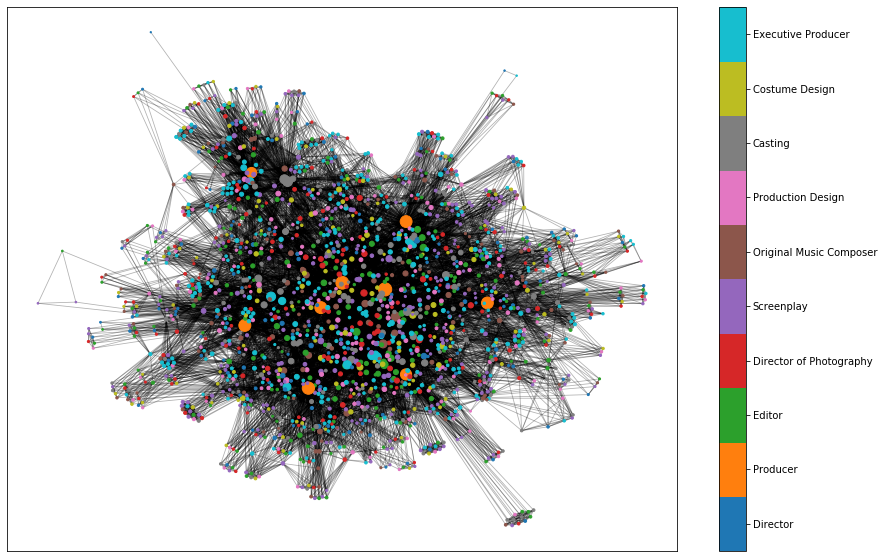

In [175]:
# coords_G_crew = nx.spring_layout(G_crew, k=0.3)
fig=plt.subplots(figsize=(15, 10))
im=nx.draw_networkx_nodes(G_crew_c_p, coords_G_crew_p,node_size=np.array(list(nx.degree_centrality(G_crew_p).values()))*1000,node_color=labels_c_job_p, cmap='tab10',vmin=0,vmax =10)
nx.draw_networkx_edges(G_crew_p, coords_G_crew_p, alpha=0.3, width=0.8,weight = True)


cbar = plt.colorbar(im, ticks=np.array(range(10))+0.5)
cbar.set_ticklabels(list(dict_job_number.keys()))  


top producers are more concentrated than top directors, surrounded by all the other crews.

In [110]:
df_crews_list_p['degree_centrality'] = list(nx.degree_centrality(G_crew_p).values())
# df_crews_list['degree_centrality'] = list(nx.degree_centrality(G_crew).values())

In [111]:
df_crews_list_p[df_crews_list_p['job'] == 'Producer']

,id,job,degree_centrality
Jerry Bruckheimer,1,Producer,0.125652
Brian Grazer,31,Producer,0.139729
Neal H. Moritz,40,Producer,0.173618
John Davis,84,Producer,0.142857
Joel Silver,128,Producer,0.149635
Arnon Milchan,196,Producer,0.163191
Tim Bevan,345,Producer,0.142857
Scott Rudin,356,Producer,0.139729
Gary Lucchesi,609,Producer,0.110010


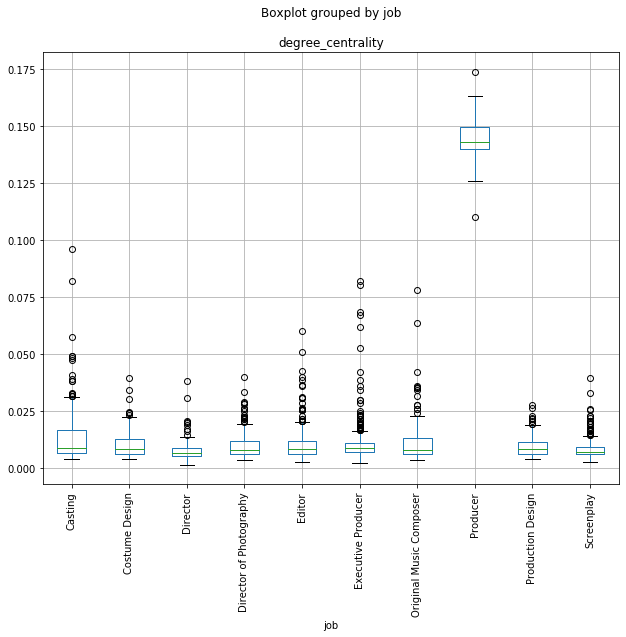

In [123]:
fig, ax = plt.subplots(figsize=(10,8))
df_crews_list_p.boxplot(column=['degree_centrality'], by='job', ax=ax,rot='vertical')

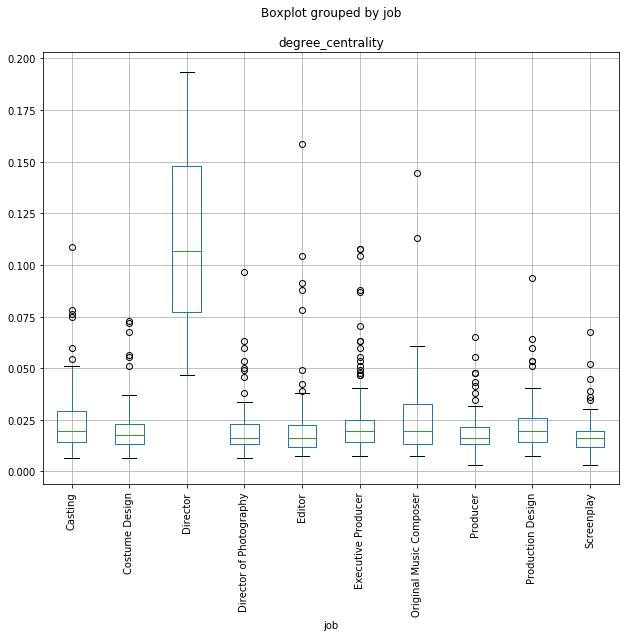

In [124]:
fig, ax = plt.subplots(figsize=(10,8))
df_crews_list_d.boxplot(column=['degree_centrality'], by='job', ax=ax,rot='vertical')
# ax.set_xticklabels(labels,rotation=120)

This might indicate that in movie industry, Top directors prefer to work with certain crews, while producers have no such preference.This can also be observed from there box plot, we can see that in the the degree centrality of director is closer to other crews than .